In [51]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.mixture import GaussianMixture
import scipy.stats as st
from sklearn.model_selection import train_test_split

# Load the CSV files
train_data = pd.read_csv('./data/fashion-mnist_train.csv')#.sample(1000)
test_data = pd.read_csv('./data/fashion-mnist_test.csv')#.sample(1000)

X_train = train_data.iloc[:, 1:].values
y_train = train_data.iloc[:, 0].values  

X_test = test_data.iloc[:, 1:].values    
y_test = test_data.iloc[:, 0].values  

label_to_name = {
    0: "Pullover",
    1: "Coat",
}

              precision    recall  f1-score   support

           0       0.92      0.87      0.90      1000
           1       0.88      0.93      0.90      1000

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000

[[869 131]
 [ 71 929]]


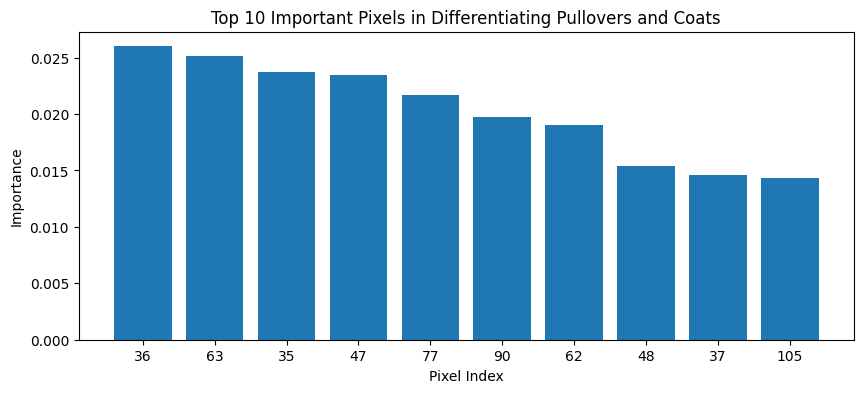

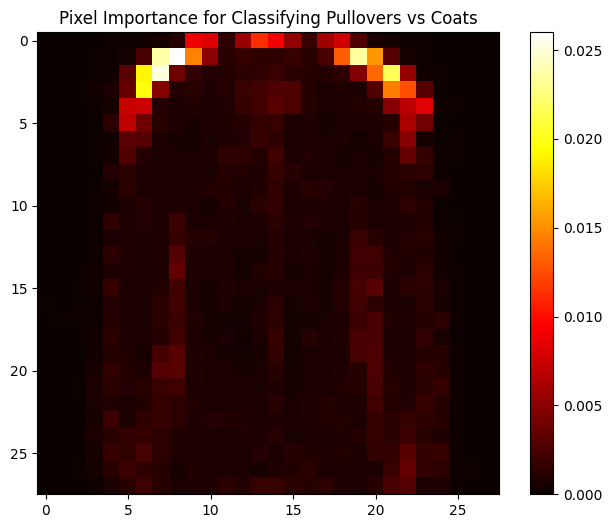

In [52]:
# Filter out only pullovers (class 2) and coats (class 4)
pullover_class = 2
coat_class = 4

# Create a mask to select only pullovers and coats
train_mask = (y_train == pullover_class) | (y_train == coat_class)
test_mask = (y_test == pullover_class) | (y_test == coat_class)

# Filter training and test data
X_train_filtered = X_train[train_mask]
y_train_filtered = y_train[train_mask]
X_test_filtered = X_test[test_mask]
y_test_filtered = y_test[test_mask]

# Convert labels to binary: 0 for pullover, 1 for coat
y_train_filtered = np.where(y_train_filtered == pullover_class, 0, 1)
y_test_filtered = np.where(y_test_filtered == pullover_class, 0, 1)

# Reshape the images into vectors 
X_train_flattened = X_train_filtered.reshape(X_train_filtered.shape[0], -1)
X_test_flattened = X_test_filtered.reshape(X_test_filtered.shape[0], -1)

# Train the RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_flattened, y_train_filtered)

# Make predictions on the test set
y_pred = rf_clf.predict(X_test_flattened)

# Classification report and confusion matrix
print(classification_report(y_test_filtered, y_pred))
print(confusion_matrix(y_test_filtered, y_pred))

# Feature Importance
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort by importance

# Plot the top 10 important pixels
plt.figure(figsize=(10, 4))
plt.bar(range(10), importances[indices[:10]], align="center")
plt.xticks(range(10), indices[:10])
plt.xlabel("Pixel Index")
plt.ylabel("Importance")
plt.title("Top 10 Important Pixels in Differentiating Pullovers and Coats")
plt.show()

# Visualize the most important pixel regions (reshaping the feature importances)
importance_image = importances.reshape(28, 28)
plt.figure(figsize=(8, 6))
plt.imshow(importance_image, cmap='hot', interpolation='nearest')
plt.title("Pixel Importance for Classifying Pullovers vs Coats")
plt.colorbar()
plt.show()

In [53]:
importances

array([0.00000000e+00, 3.25208898e-06, 2.23433145e-05, 6.57909565e-05,
       1.78526811e-04, 1.97388326e-04, 2.26327786e-04, 4.31119649e-04,
       1.08185533e-03, 8.86076555e-03, 8.21396858e-03, 1.46750467e-03,
       5.59887182e-03, 1.12573049e-02, 9.11700740e-03, 5.33242430e-03,
       1.67997233e-03, 5.87443717e-03, 7.62591175e-03, 2.70427879e-03,
       6.89976157e-04, 4.91967775e-04, 2.58431601e-04, 1.61699508e-04,
       3.92555808e-05, 4.00776782e-05, 8.73020950e-06, 0.00000000e+00,
       5.18519440e-06, 4.11034832e-07, 4.76061515e-05, 1.10748581e-04,
       1.16511087e-04, 4.94996746e-04, 2.51440531e-03, 2.36855303e-02,
       2.59963776e-02, 1.46193361e-02, 4.99335508e-03, 1.14928941e-03,
       1.63313835e-03, 1.46741125e-03, 1.40404372e-03, 1.69467584e-03,
       1.13098940e-03, 2.39585911e-03, 1.31126661e-02, 2.34880167e-02,
       1.54137082e-02, 2.92683894e-03, 5.93275288e-04, 1.47187922e-04,
       2.97229701e-05, 1.09476166e-05, 4.00005378e-06, 0.00000000e+00,
      

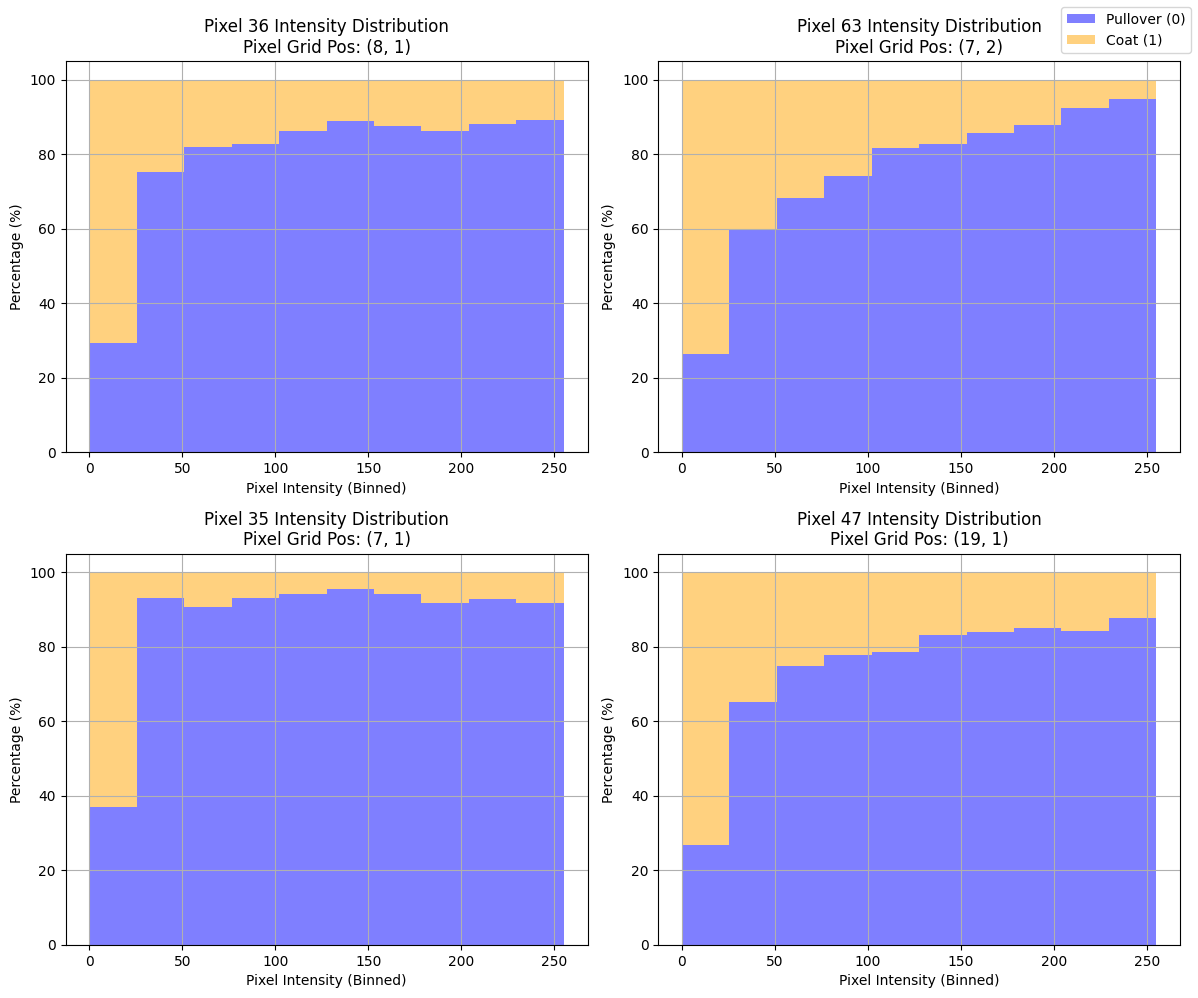

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Get the indices of the top 10 important pixels
top_pixels = indices[:10]

# Function to calculate and plot the percentage of pullovers and coats for binned intensity values
def plot_combined_coat_pullover_percentage(ax, pixel_index, num_bins=10):
    # Pixel values for pullovers and coats
    pullover_pixels = X_train_filtered[y_train_filtered == 0][:, pixel_index]
    coat_pixels = X_train_filtered[y_train_filtered == 1][:, pixel_index]

    # Define intensity bins
    bins = np.linspace(0, 255, num_bins + 1)
    
    # Bin the pixel values for pullovers and coats
    pullover_binned, _ = np.histogram(pullover_pixels, bins=bins)
    coat_binned, _ = np.histogram(coat_pixels, bins=bins)

    # Total number of examples in each bin
    total_binned = pullover_binned + coat_binned

    # Calculate percentages, avoiding division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        pullover_percentages = np.where(total_binned != 0, (pullover_binned / total_binned) * 100, 0)
        coat_percentages = np.where(total_binned != 0, (coat_binned / total_binned) * 100, 0)

    # Get the midpoints of the bins for plotting
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Stacked bar chart for percentages
    ax.bar(bin_centers, pullover_percentages, width=(bins[1] - bins[0]), color='blue', label='Pullover (0)', alpha=0.5)
    ax.bar(bin_centers, coat_percentages, width=(bins[1] - bins[0]), bottom=pullover_percentages, color='orange', label='Coat (1)', alpha=0.5)
    
    # Labels and title
    ax.set_xlabel('Pixel Intensity (Binned)')
    ax.set_ylabel('Percentage (%)')
    ax.set_title(f'Pixel {pixel_index} Intensity Distribution\nPixel Grid Pos: ({pixel_index % 28}, {pixel_index // 28})')
    ax.grid(True)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2x2 grid of subplots

# Plot the top 4 important pixels
for i in range(4):
    row = i // 2  
    col = i % 2 
    plot_combined_coat_pullover_percentage(axes[row, col], top_pixels[i], num_bins=10)

# Add legend outside the subplots
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout()
plt.show()


In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.mixture import GaussianMixture

# Fit GMM models for each class
n_components = 5  
gmm_models = {}
for label in np.unique(y_train_filtered):
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(X_train_flattened[y_train_filtered == label])  # Use flattened training data
    gmm_models[label] = gmm

# Make predictions on the test set
y_pred = np.array([
    np.argmax([gmm_models[label].score(X_test_flattened[i].reshape(1, -1)) for label in gmm_models])
    for i in range(X_test_flattened.shape[0])
])

# Classification report and confusion matrix
print(classification_report(y_test_filtered, y_pred))
print(confusion_matrix(y_test_filtered, y_pred))



              precision    recall  f1-score   support

           0       0.65      0.75      0.69      1000
           1       0.70      0.59      0.64      1000

    accuracy                           0.67      2000
   macro avg       0.67      0.67      0.67      2000
weighted avg       0.67      0.67      0.67      2000

[[749 251]
 [411 589]]


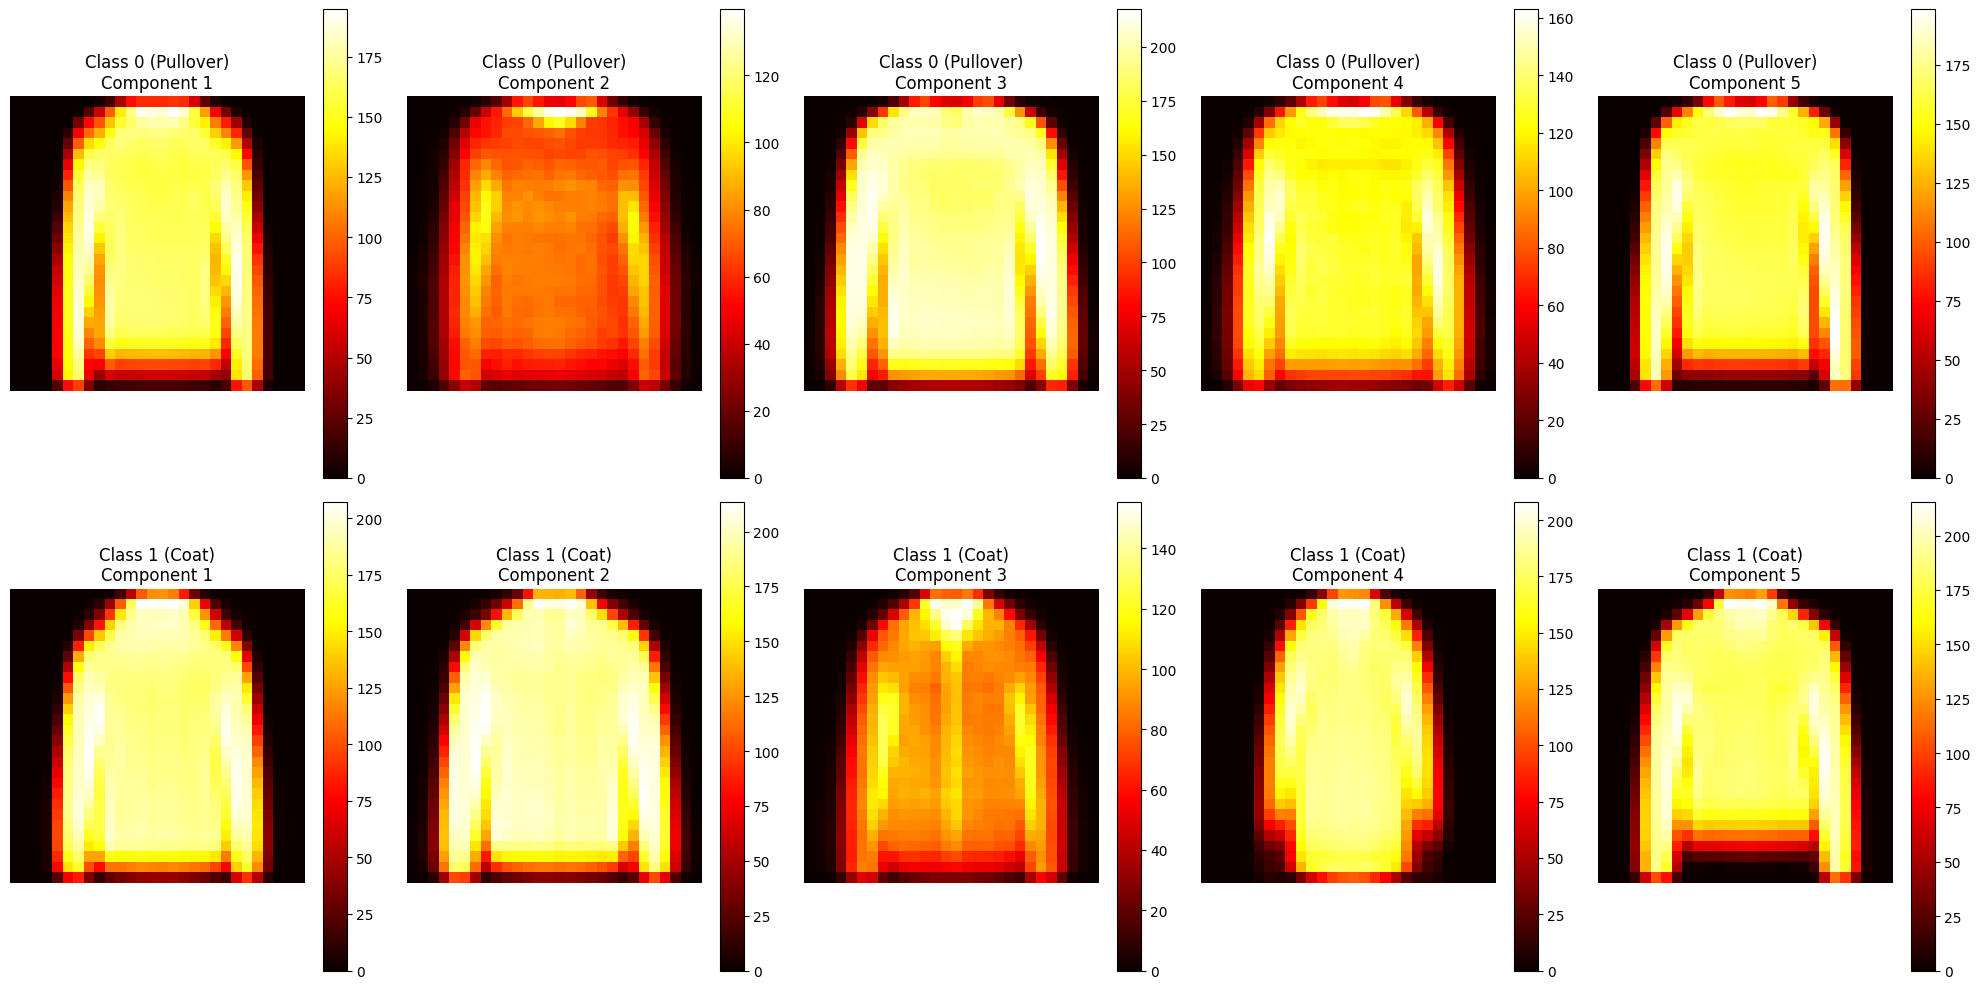

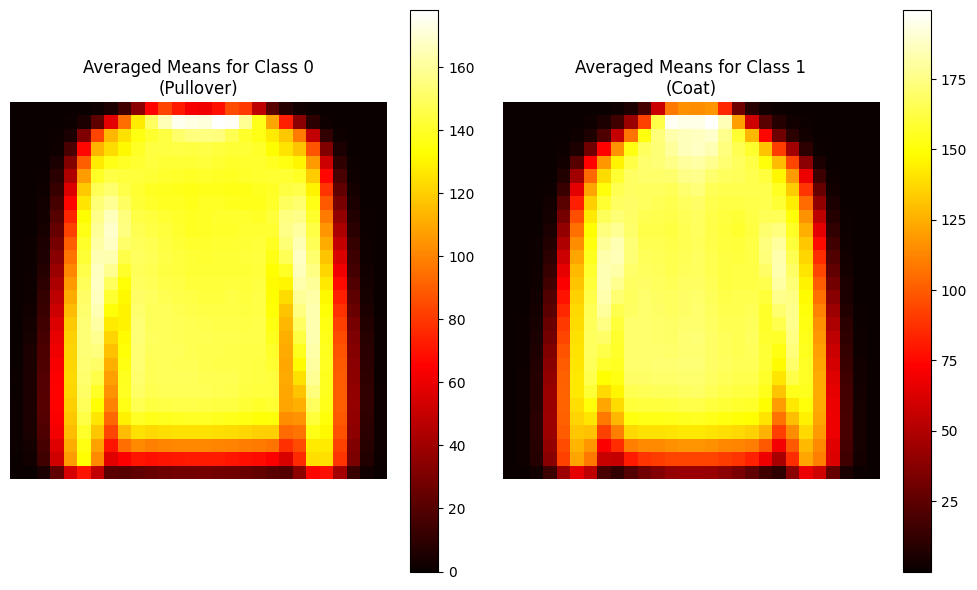

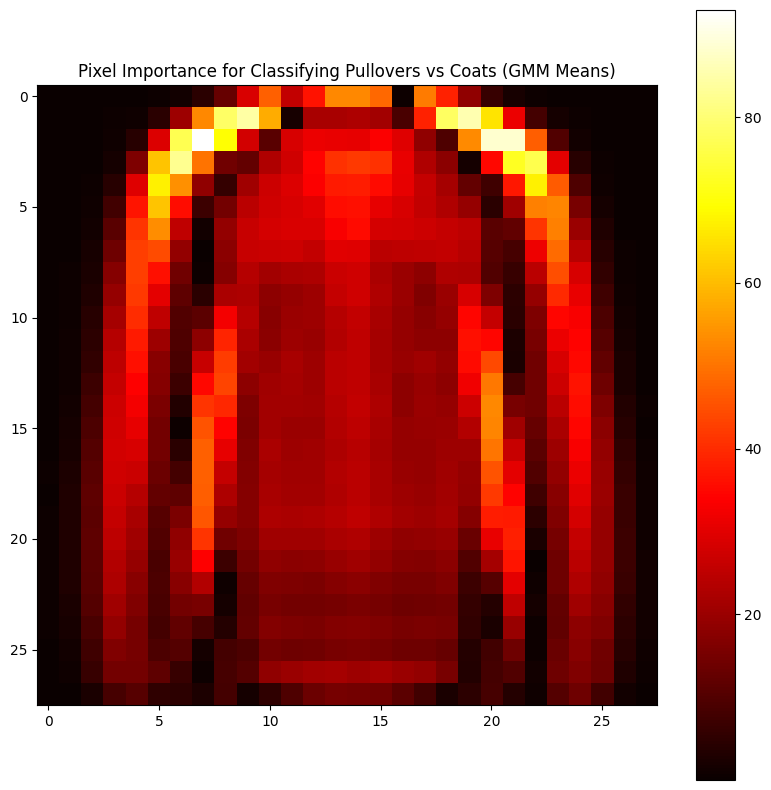

In [60]:

means = {}
for label in gmm_models:
    means[label] = gmm_models[label].means_.flatten()  

# Visualize means for each class and each component
num_classes = len(gmm_models)
plt.figure(figsize=(20, 10))
for i, label in enumerate(gmm_models):
    for j in range(n_components):
        plt.subplot(num_classes, n_components, i * n_components + j + 1)
        component_mean = gmm_models[label].means_[j].reshape(28, 28)
        plt.imshow(component_mean, cmap='hot', interpolation='nearest')
        plt.title(f'Class {label} ({label_to_name[label]})\nComponent {j + 1}')
        plt.axis('off')  
        plt.colorbar()

plt.tight_layout()
plt.show()

averaged_means = np.array([np.mean(gmm_models[label].means_, axis=0) for label in gmm_models])  # Average means

plt.figure(figsize=(10, 6))
for i, label in enumerate(gmm_models):
    plt.subplot(1, num_classes, i + 1)
    plt.imshow(averaged_means[i].reshape(28, 28), cmap='hot', interpolation='nearest')
    plt.title(f'Averaged Means for Class {label}\n({label_to_name[label]})')
    plt.axis('off') 
    plt.colorbar()

plt.tight_layout()
plt.show()


mean_importance_image = np.abs((averaged_means[0]-averaged_means[1])).reshape(28, 28)
plt.figure(figsize=(10, 10))
plt.imshow(mean_importance_image, cmap='hot', interpolation='nearest')
plt.title("Pixel Importance for Classifying Pullovers vs Coats (GMM Means)")
plt.colorbar()
plt.show()


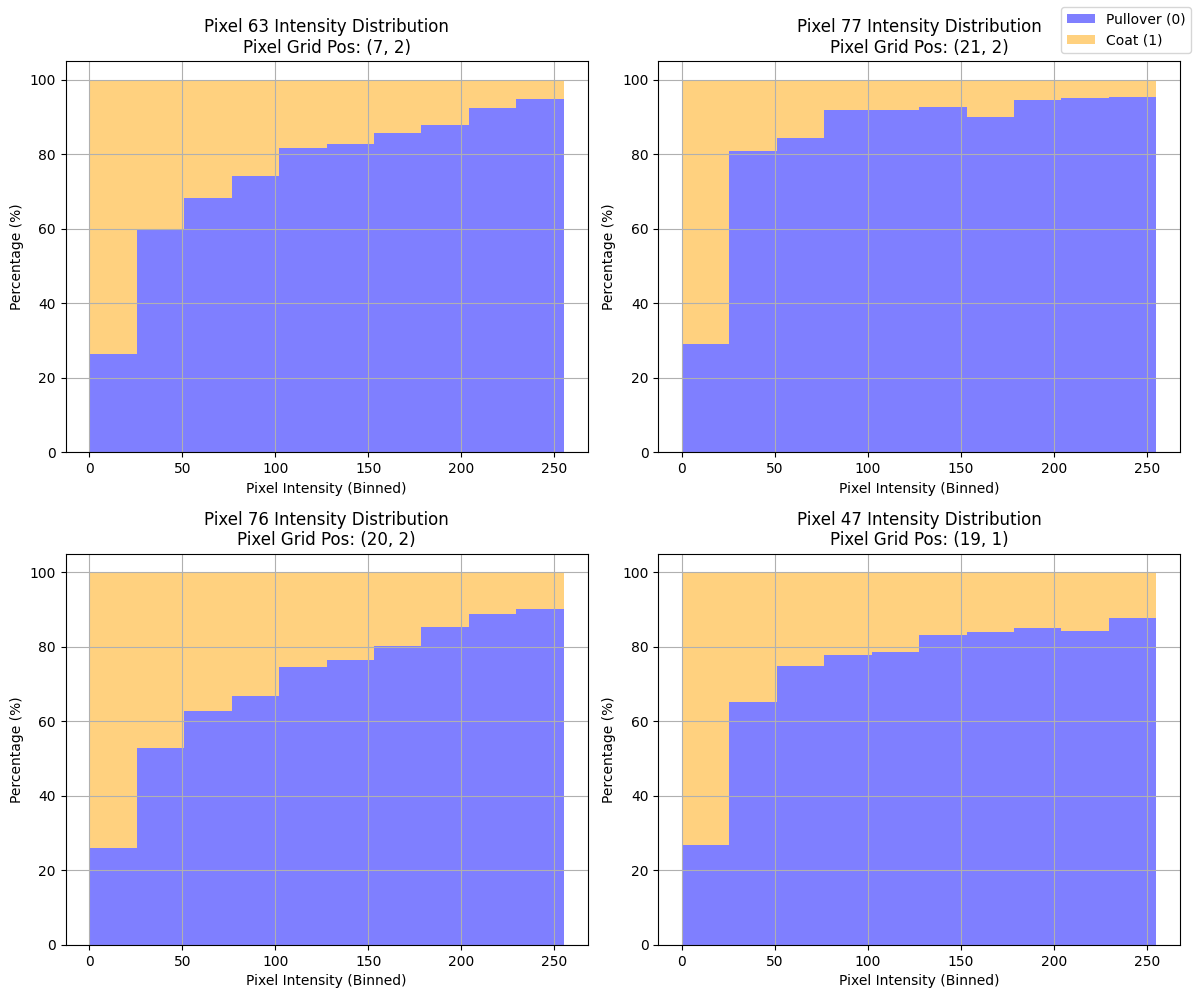

In [58]:
import numpy as np
import matplotlib.pyplot as plt

importances = np.abs((averaged_means[0]-averaged_means[1]))
top_pixels = np.argsort(importances)[::-1]

# Function to calculate and plot the percentage of pullovers and coats for binned intensity values
def plot_combined_coat_pullover_percentage(ax, pixel_index, num_bins=10):
    # Pixel values for pullovers and coats
    pullover_pixels = X_train_filtered[y_train_filtered == 0][:, pixel_index]
    coat_pixels = X_train_filtered[y_train_filtered == 1][:, pixel_index]

    bins = np.linspace(0, 255, num_bins + 1)
    
    # Bin the pixel values for pullovers and coats
    pullover_binned, _ = np.histogram(pullover_pixels, bins=bins)
    coat_binned, _ = np.histogram(coat_pixels, bins=bins)

    # Total number of examples in each bin
    total_binned = pullover_binned + coat_binned

    with np.errstate(divide='ignore', invalid='ignore'):
        pullover_percentages = np.where(total_binned != 0, (pullover_binned / total_binned) * 100, 0)
        coat_percentages = np.where(total_binned != 0, (coat_binned / total_binned) * 100, 0)

    # Get the midpoints of the bins for plotting
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Stacked bar chart for percentages
    ax.bar(bin_centers, pullover_percentages, width=(bins[1] - bins[0]), color='blue', label='Pullover (0)', alpha=0.5)
    ax.bar(bin_centers, coat_percentages, width=(bins[1] - bins[0]), bottom=pullover_percentages, color='orange', label='Coat (1)', alpha=0.5)
    
    ax.set_xlabel('Pixel Intensity (Binned)')
    ax.set_ylabel('Percentage (%)')
    ax.set_title(f'Pixel {pixel_index} Intensity Distribution\nPixel Grid Pos: ({pixel_index % 28}, {pixel_index // 28})')
    ax.grid(True)

# Number of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10)) 

# Plot the top 4 important pixels
for i in range(4):
    row = i // 2  # Row index for the subplot
    col = i % 2   # Column index for the subplot
    plot_combined_coat_pullover_percentage(axes[row, col], top_pixels[i], num_bins=10)

# Add legend outside the subplots
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout()
plt.show()